In [166]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import random

In [169]:
padding = 3
with open('names.txt', 'r') as file:
    names = file.readlines()
names = ['.'*padding+name.strip()+'.' for name in names]
names[:3]

['...emma.', '...olivia.', '...ava.']

In [35]:
unique_char = set(list(chain(*names)))
length = len(unique_char)
chtoi = {i:en for en, i in enumerate(sorted(list(unique_char)))}
itoch = {v:k for k,v in chtoi.items()}
length

27

In [197]:
random.seed(42)
random.shuffle(names)
def build_dataset(names):
    Xs, Ys = [], []
    for word in names:
        for c1, c2, c3, c4 in zip(word, word[1:], word[2:], word[3:]):
            Xs.append([chtoi[c1],chtoi[c2],chtoi[c3]])
            Ys.append(chtoi[c4])
    Xs = torch.tensor(Xs)
    Ys = torch.tensor(Ys)
    print(Xs.shape, Ys.shape )
    return Xs, Ys
n1 = int(len(names)*.8)
n2 = int(len(names)*.9)
Xtra, Ytra = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xtes, Yes = build_dataset(names[n2:])

torch.Size([182397, 3]) torch.Size([182397])
torch.Size([22791, 3]) torch.Size([22791])
torch.Size([22958, 3]) torch.Size([22958])


In [208]:
embedding_dim = 5
batch_size = 128
hid_dim = [padding*embedding_dim, 500]
g = torch.Generator().manual_seed(2147483647)
lr = .5
embed = torch.rand((length, embedding_dim), requires_grad=True, generator=g)
print(f'{embed[Xtra].shape=}')

W1 = torch.randn(hid_dim[0],hid_dim[1], requires_grad=True, generator=g)
b1 = torch.randn(hid_dim[1], requires_grad=True, generator=g)
W2 = torch.randn(hid_dim[1],length, requires_grad=True, generator=g)
b2 = torch.randn(length, requires_grad=True, generator=g)
parameters = [embed, W1, b1, W2, b2]
print(f'{W1.shape=}, {b1.shape=}, {W2.shape=}, {b2.shape=}')

for i in range(200000):
    batch = torch.randint(0, Xtra.shape[0], (batch_size,))
    hidden = torch.tanh(embed[Xtra[batch]].view(-1, hid_dim[0]) @ W1 + b1)
    out = hidden @ W2 + b2
    loss = F.cross_entropy(out, torch.tensor(Ytra[batch])) 
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    if i % 1000 == 0:
        print(f'loss={loss.item()}')
    if  i == 100000:
        lr *= .1
    # if loss.item() < 2.1 and i > 500:
    #     print(f'loss={loss.item()} iteration={i}')
    #     break
print(f'loss={loss.item()}')

embed[Xtra].shape=torch.Size([182397, 3, 5])
W1.shape=torch.Size([15, 500]), b1.shape=torch.Size([500]), W2.shape=torch.Size([500, 27]), b2.shape=torch.Size([27])
loss=40.92203903198242


/tmp/ipykernel_17131/4260014006.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.cross_entropy(out, torch.tensor(Ytra[batch]))


loss=10.565754890441895
loss=9.90065860748291
loss=7.065001010894775
loss=8.354973793029785
loss=6.642632961273193
loss=10.23415756225586
loss=7.384223461151123
loss=3.598719358444214
loss=2.7106974124908447
loss=2.3838417530059814
loss=2.521479368209839
loss=2.514878749847412
loss=2.4655609130859375
loss=2.5829248428344727
loss=2.4420928955078125
loss=2.3697118759155273
loss=2.641343593597412
loss=2.4658443927764893
loss=2.3612117767333984
loss=2.4259750843048096
loss=2.334925413131714
loss=2.3222506046295166
loss=2.3178319931030273
loss=2.565744400024414
loss=2.6435253620147705
loss=2.6990294456481934
loss=2.5055577754974365
loss=2.1876280307769775
loss=2.2961182594299316
loss=2.298614263534546
loss=2.3904800415039062
loss=2.2482802867889404
loss=2.263498067855835
loss=2.5377073287963867
loss=2.3704657554626465
loss=2.2313389778137207
loss=2.229545831680298
loss=2.322115659713745
loss=2.32208251953125
loss=2.190845489501953
loss=2.4615302085876465
loss=2.610825300216675
loss=2.254947

In [209]:
hidden = torch.tanh(embed[Xval].view(-1, hid_dim[0]) @ W1 + b1)
out = hidden @ W2 + b2
loss = F.cross_entropy(out, torch.tensor(Yval)) 
loss

/tmp/ipykernel_17131/322588635.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.cross_entropy(out, torch.tensor(Yval))


tensor(2.1182, grad_fn=<NllLossBackward0>)

In [202]:
embeddings = embed.detach().numpy()
embeddings.shape
embeddings[0,0]

-0.37755325

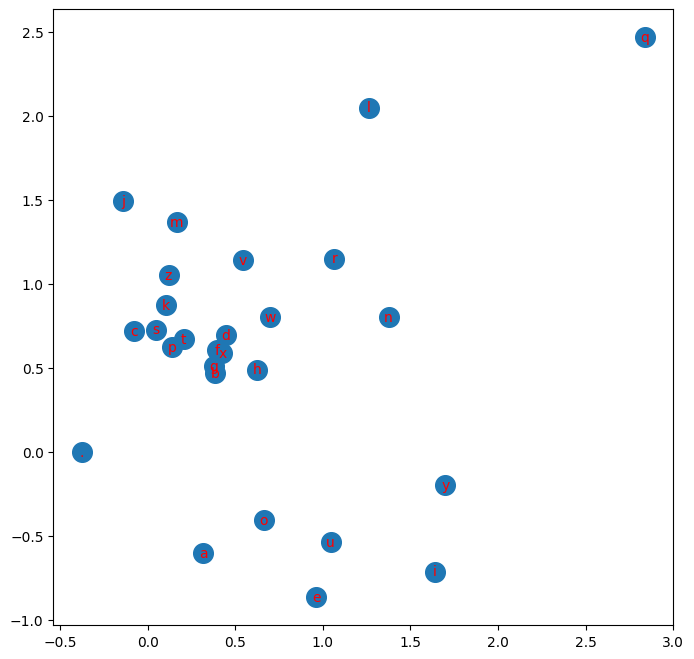

In [203]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], s=200)
for i in range(length):
    plt.text(embeddings[i,0], embeddings[i,1], itoch[i], ha='center', va='center', color='red')